# Carrier Invoice Data Analysis (H2 2025)

This notebook analyzes the carrier invoice data for the second half of 2025 (July 1 - December 31)  
extracted from ClickHouse and stored in DuckDB.

**Data Source:** `full_carrier_invoice_extraction.duckdb`  
**Date Range:** July 1, 2025 - December 31, 2025

**Author:** Gabriel Jerdhy Lapuz  
**Project:** gsr_automation

## 1. Setup and Imports

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports successful!")

✅ Imports successful!


## 2. Connect to DuckDB Database

In [2]:
# Connect to the DuckDB database
db_path = '../full_carrier_invoice_extraction.duckdb'

if not os.path.exists(db_path):
    print(f"❌ Database file not found: {db_path}")
    print("Please run the extraction script first: poetry run python src/src/full_extract_clickhouse.py")
else:
    conn = duckdb.connect(db_path, read_only=True)
    print(f"✅ Connected to DuckDB: {db_path}")

✅ Connected to DuckDB: ../full_carrier_invoice_extraction.duckdb


## 3. Database Overview

In [3]:
# List all tables
tables = conn.execute("SHOW TABLES").fetchdf()
print("📊 Available Tables:")
display(tables)

📊 Available Tables:


,name


In [5]:
# Get table schema
schema = conn.execute(
    "DESCRIBE full_carrier_invoice_data.full_carrier_invoice_data"
).fetchdf()
print(f"📋 Table Schema: {len(schema)} columns")
display(schema)

📋 Table Schema: 263 columns


,column_name,column_type,null,key,default,extra
0,version,VARCHAR,YES,None,None,None
1,recipient_number,VARCHAR,YES,None,None,None
2,account_number,VARCHAR,YES,None,None,None
3,account_country_territory,VARCHAR,YES,None,None,None
4,invoice_date,VARCHAR,YES,None,None,None
...,...,...,...,...,...,...
258,_peerdb_version,BIGINT,YES,None,None,None
259,_extracted_at,TIMESTAMP WITH TIME ZONE,YES,None,None,None
260,_source_table,VARCHAR,YES,None,None,None
261,_dlt_load_id,VARCHAR,NO,None,None,None


In [ ]:
# Get total row count
total_rows = conn.execute("SELECT COUNT(*) as total FROM full_carrier_invoice_data").fetchone()[0]
print(f"📊 Total Rows: {total_rows:,}")

## 4. Transaction Date Analysis

In [ ]:
# Get transaction date statistics
date_stats = conn.execute("""
    SELECT
        MIN(transaction_date) as min_date,
        MAX(transaction_date) as max_date,
        COUNT(DISTINCT transaction_date) as distinct_dates,
        COUNT(*) as total_records
    FROM full_carrier_invoice_data
    WHERE transaction_date IS NOT NULL AND transaction_date != ''
""").fetchdf()

print("📅 Transaction Date Statistics:")
display(date_stats)

In [8]:
# Get top 20 transaction dates by record count
top_dates = conn.execute(
    """
    SELECT
        transaction_date,
        shipment_date,
        COUNT(*) as record_count
    FROM full_carrier_invoice_data.full_carrier_invoice_data
    WHERE transaction_date IS NOT NULL AND transaction_date != ''
    GROUP BY transaction_date, shipment_date
    ORDER BY transaction_date DESC
    LIMIT 20
"""
).fetchdf()

print("📊 Top 20 Transaction Dates by Record Count:")
display(top_dates)

📊 Top 20 Transaction Dates by Record Count:


,transaction_date,shipment_date,record_count
0,9/9/2025,,10
1,9/30/2025,,18
2,9/29/2025,,58
3,9/25/2025,,8
4,9/24/2025,,16
5,9/23/2025,,18
6,9/22/2025,,28
7,9/19/2025,,6
8,9/17/2025,,8
9,9/16/2025,,8


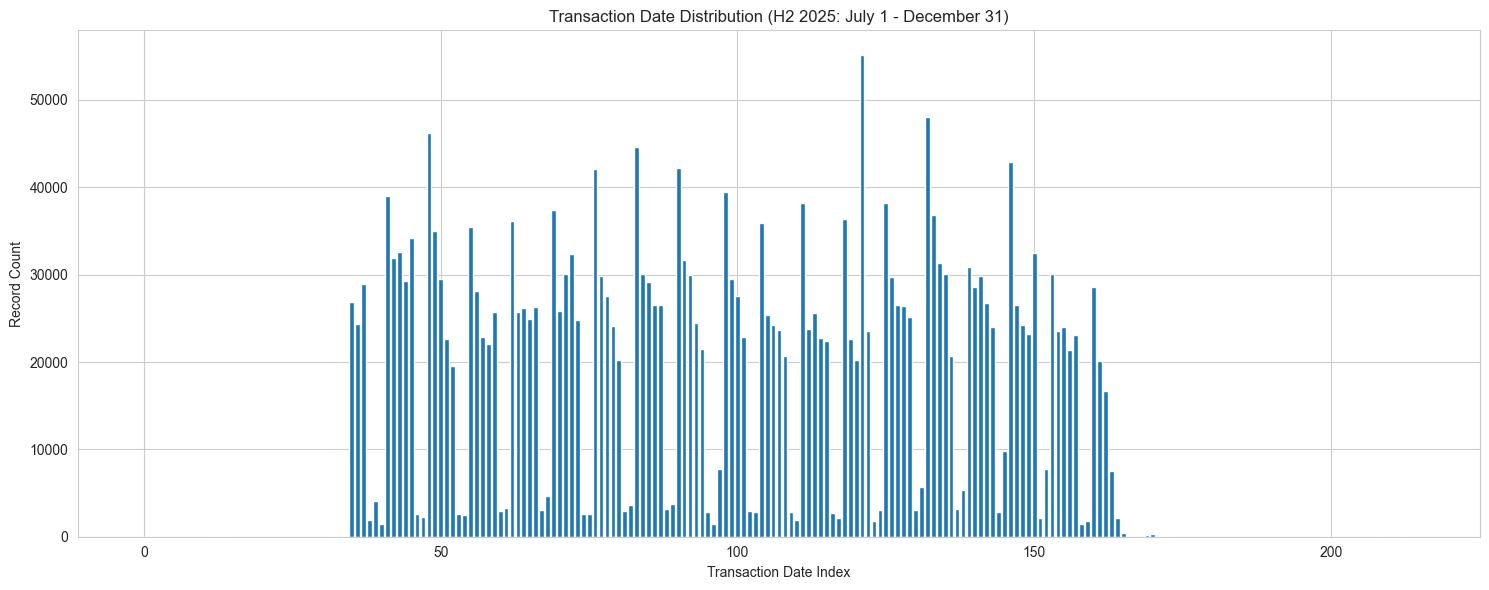

Total distinct dates: 215


In [9]:
# Plot transaction date distribution
date_distribution = conn.execute(
    """
    SELECT
        transaction_date,
        COUNT(*) as record_count
    FROM full_carrier_invoice_data.full_carrier_invoice_data
    WHERE transaction_date IS NOT NULL AND transaction_date != ''
    GROUP BY transaction_date
    ORDER BY transaction_date
"""
).fetchdf()

plt.figure(figsize=(15, 6))
plt.bar(range(len(date_distribution)), date_distribution['record_count'])
plt.xlabel('Transaction Date Index')
plt.ylabel('Record Count')
plt.title('Transaction Date Distribution (H2 2025: July 1 - December 31)')
plt.tight_layout()
plt.show()

print(f"Total distinct dates: {len(date_distribution)}")

## 5. Tracking Number Analysis

In [ ]:
# Get tracking number statistics
tracking_stats = conn.execute("""
    SELECT
        COUNT(DISTINCT tracking_number) as unique_tracking_numbers,
        COUNT(*) as total_records
    FROM full_carrier_invoice_data
    WHERE tracking_number IS NOT NULL AND tracking_number != ''
""").fetchdf()

print("📦 Tracking Number Statistics:")
display(tracking_stats)

In [ ]:
# Sample tracking numbers
sample_tracking = conn.execute("""
    SELECT
        tracking_number,
        transaction_date,
        invoice_date,
        account_number
    FROM full_carrier_invoice_data
    WHERE tracking_number IS NOT NULL AND tracking_number != ''
    LIMIT 10
""").fetchdf()

print("📦 Sample Tracking Numbers:")
display(sample_tracking)

## 6. Account Number Analysis

In [ ]:
# Get account number statistics
account_stats = conn.execute("""
    SELECT
        account_number,
        COUNT(*) as record_count,
        COUNT(DISTINCT tracking_number) as unique_tracking_numbers
    FROM full_carrier_invoice_data
    WHERE account_number IS NOT NULL AND account_number != ''
    GROUP BY account_number
    ORDER BY record_count DESC
    LIMIT 20
""").fetchdf()

print("💳 Top 20 Account Numbers by Record Count:")
display(account_stats)

## 7. Custom Queries

Use this section to run your own custom queries on the data.

In [ ]:
# Example: Query specific date range
query = """
    SELECT *
    FROM full_carrier_invoice_data
    WHERE transaction_date >= '2025-08-01' AND transaction_date <= '2025-08-31'
    LIMIT 100
"""

result = conn.execute(query).fetchdf()
print(f"Query returned {len(result)} rows")
display(result.head())

In [ ]:
# Example: Export query results to CSV
output_path = '../data/output/custom_query_results.csv'
result.to_csv(output_path, index=False)
print(f"✅ Results exported to: {output_path}")

## 8. Data Quality Checks

In [ ]:
# Check for NULL values in key columns
null_check = conn.execute("""
    SELECT
        COUNT(*) as total_rows,
        SUM(CASE WHEN tracking_number IS NULL OR tracking_number = '' THEN 1 ELSE 0 END) as null_tracking_number,
        SUM(CASE WHEN transaction_date IS NULL OR transaction_date = '' THEN 1 ELSE 0 END) as null_transaction_date,
        SUM(CASE WHEN invoice_date IS NULL OR invoice_date = '' THEN 1 ELSE 0 END) as null_invoice_date,
        SUM(CASE WHEN account_number IS NULL OR account_number = '' THEN 1 ELSE 0 END) as null_account_number
    FROM full_carrier_invoice_data
""").fetchdf()

print("🔍 NULL Value Check:")
display(null_check)

In [12]:
# Custom query example - modify as needed
custom_query = """
SELECT 
    distinct shipment_date
FROM full_carrier_invoice_data.full_carrier_invoice_data
order by shipment_date desc

"""

result_df = conn.execute(custom_query).df()
display(result_df)
# Save to CSV
# result_df.to_csv("tracking_results_33.csv", index=False)

,shipment_date
0,2025-11-04
1,2025-11-03
2,2025-10-31
3,2025-10-29
4,2025-10-28
5,2025-10-27
6,2025-10-24
7,2025-10-23
8,2025-10-22
9,2025-10-21


In [16]:
# Custom query example - modify as needed
custom_query = """
SELECT 
     *
FROM full_carrier_invoice_data.full_carrier_invoice_data
where tracking_number = '1ZJ201R96720248882'
order by shipment_date desc

"""

result_df = conn.execute(custom_query).df()
display(result_df)
# Save to CSV
# result_df.to_csv("tracking_results_33.csv", index=False)

,version,recipient_number,account_number,account_country_territory,invoice_date,invoice_number,invoice_type_code,invoice_type_detail_code,account_tax_id,invoice_currency_code,invoice_amount,transaction_date,pickup_record_number,lead_shipment_number,world_ease_number,shipment_reference_number_1,shipment_reference_number_2,bill_option_code,package_quantity,oversize_quantity,tracking_number,package_reference_number_1,package_reference_number_2,package_reference_number_3,package_reference_number_4,package_reference_number_5,entered_weight,entered_weight_unit_of_measure,billed_weight,billed_weight_unit_of_measure,container_type,billed_weight_type,package_dimensions,zone,charge_category_code,charge_category_detail_code,charge_source,type_code_1,type_detail_code_1,type_detail_value_1,type_code_2,type_detail_code_2,type_detail_value_2,charge_classification_code,charge_description_code,charge_description,charged_unit_quantity,basis_currency_code,basis_value,tax_indicator,transaction_currency_code,incentive_amount,net_amount,miscellaneous_currency_code,miscellaneous_incentive_amount,miscellaneous_net_amount,alternate_invoicing_currency_code,alternate_invoice_amount,invoice_exchange_rate,tax_variance_amount,currency_variance_amount,invoice_level_charge,invoice_due_date,alternate_invoice_number,store_number,customer_reference_number,sender_name,sender_company_name,sender_address_line_1,sender_address_line_2,sender_city,sender_state,sender_postal,sender_country_territory,receiver_name,receiver_company_name,receiver_address_line_1,receiver_address_line_2,receiver_city,receiver_state,receiver_postal,receiver_country_territory,third_party_name,third_party_company_name,third_party_address_line_1,third_party_address_line_2,third_party_city,third_party_state,third_party_postal,third_party_country_territory,sold_to_name,sold_to_company_name,sold_to_address_line_1,sold_to_address_line_2,sold_to_city,sold_to_state,sold_to_postal,sold_to_country_territory,miscellaneous_address_qual_1,miscellaneous_address_1_name,miscellaneous_address_1_company_name,miscellaneous_address_1_address_line_1,miscellaneous_address_1_address_line_2,miscellaneous_address_1_city,miscellaneous_address_1_state,miscellaneous_address_1_postal,miscellaneous_address_1_country_territory,miscellaneous_address_qual_2,miscellaneous_address_2_name,miscellaneous_address_2_company_name,miscellaneous_address_2_address_line_1,miscellaneous_address_2_address_line_2,miscellaneous_address_2_city,miscellaneous_address_2_state,miscellaneous_address_2_postal,miscellaneous_address_2_country_territory,shipment_date,shipment_export_date,shipment_import_date,entry_date,direct_shipment_date,shipment_delivery_date,shipment_release_date,cycle_date,eft_date,validation_date,entry_port,entry_number,export_place,shipment_value_amount,shipment_description,entered_currency_code,customs_number,exchange_rate,master_air_waybill_number,epu,entry_type,cpc_code,line_item_number,goods_description,entered_value,duty_amount,weight,unit_of_measure,item_quantity,item_quantity_unit_of_measure,import_tax_id,declaration_number,carrier_name_clinical_trial_identification_number_sds_id,cccd_number,cycle_number,foreign_trade_reference_number,job_number,transport_mode,tax_type,tariff_code,tariff_rate,tariff_treatment_number,contact_name,class_number,document_type,office_number,document_number,duty_value,total_value_for_duty,excise_tax_amount,excise_tax_rate,gst_amount,gst_rate,order_in_council,origin_country_territory,sima_access,tax_value,total_customs_amount,miscellaneous_line_1,miscellaneous_line_2,miscellaneous_line_3,miscellaneous_line_4,miscellaneous_line_5,payor_role_code,miscellaneous_line_7,miscellaneous_line_8,miscellaneous_line_9,miscellaneous_line_10,miscellaneous_line_11,duty_rate,vat_basis_amount,vat_amount,vat_rate,other_basis_amount,other_amount,other_rate,other_customs_number_indicator,other_customs_number,customs_office_name,package_dimension_unit_of_measure,original_shipment_package_quantity,corrected_zone,t

In [13]:
# Custom query example - modify as needed
custom_query = """
SELECT 
    distinct transaction_date
FROM full_carrier_invoice_data.full_carrier_invoice_data
order by transaction_date desc

"""

result_df = conn.execute(custom_query).df()
display(result_df)
# Save to CSV
# result_df.to_csv("tracking_results_33.csv", index=False)

,transaction_date
0,9/9/2025
1,9/30/2025
2,9/29/2025
3,9/25/2025
4,9/24/2025
...,...
210,08/09/2025
211,07/26/2025
212,07/19/2025
213,07/12/2025


## 9. Close Connection

In [ ]:
# Close the database connection
conn.close()
print("✅ Database connection closed")